# Chapter 7

This file is used for the computations used in the LDM book, Chapter 7, on supervised learning.

In [2]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

from functools import reduce
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.utils import resample

# Datasets
from sklearn import datasets as data
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA

# Algorithms
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Performance
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
from pandas.plotting import scatter_matrix, radviz

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', serif = 'Computer Modern Roman', size = 12)

def beep(): os.system("printf '\a'")

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

### Example 2.2. Recognizing faces

A security company is developing a face recognition system (Olivetti faces dataset).

We start by loading the dataset with the faces. We load all targets for which at least 50 images exist in the database, which leads to a total of 12 classes:

* Ariel Sharon 
* Colin Powell
* Donald Rumsfeld
* George W Bush
* Gerhard Schroeder
* Hugo Chavez
* Jacques Chirac
* Jean Chretien
* John Ashcroft
* Junichiro Koizumi
* Serena Williams
* Tony Blair

Structure:
	 - target_names -> array(little endian Unicode 17 str)
	 - target       -> array(int)
	 - images       -> array(float32)
	 - DESCR        -> str
	 - data         -> array(float32)


<IPython.core.display.Javascript object>


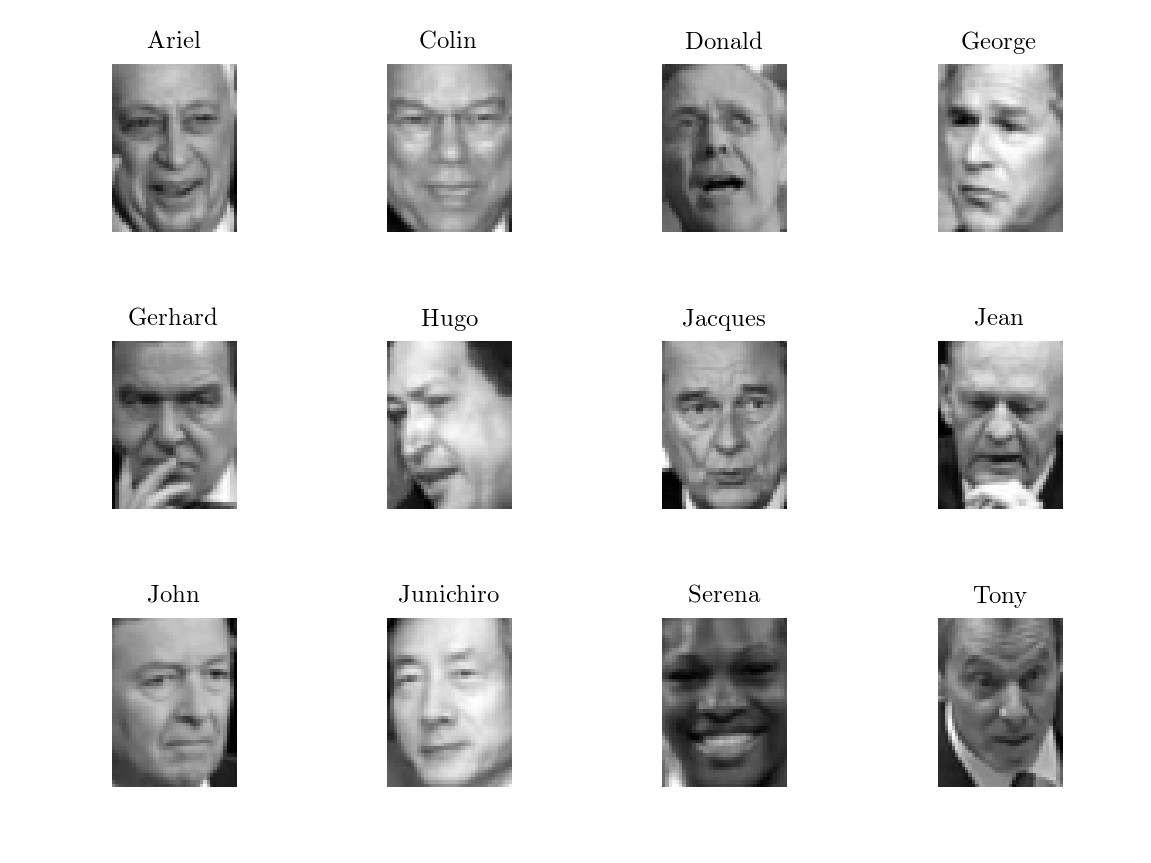

Classes: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

Total number of images: 1560
Image size: 50 x 37

Number of images per class:
Class 0 (Ariel Sharon): 77
Class 1 (Colin Powell): 236
Class 2 (Donald Rumsfeld): 121
Class 3 (George W Bush): 530
Class 4 (Gerhard Schroeder): 109
Class 5 (Hugo Chavez): 71
Class 6 (Jacques Chirac): 52
Class 7 (Jean Chretien): 55
Class 8 (John Ashcroft): 53
Class 9 (Junichiro Koizumi): 60
Class 10 (Serena Williams): 52
Class 11 (Tony Blair): 144


In [3]:
people = data.fetch_lfw_people(min_faces_per_person=50, resize=0.4)
#print(people)
print('Structure:')
print('\t - target_names -> array(little endian Unicode 17 str)')
print('\t - target       -> array(int)')
print('\t - images       -> array(float32)')
print('\t - DESCR        -> str')
print('\t - data         -> array(float32)')

# Get dimensions 
nP, w, h = people.images.shape
targets = list(people.target)

fig, axes = plt.subplots(nrows=3, ncols=4)

# Print sample faces
for i in range(12): 
    plt.subplot(3, 4, i+1)
    idx = targets.index(i)
    plt.imshow(people.images[idx], cmap=plt.cm.gray)
    name = people.target_names[i].split()
    plt.title(name[0], fontsize=10)
    plt.axis('off')

fig.tight_layout()
plt.show()

plt.savefig('faces.pdf')

print('Classes:', people.target_names)
print('\nTotal number of images:', nP)
print('Image size: %d x %d' % (w, h))

print('\nNumber of images per class:')
for i in range(len(people.target_names)):
    print('Class %d (' % i + people.target_names[i] + '):', len(list(filter(lambda x: x == i, targets))))

Next, we separate the data into a training and a testset in a random way. Note that `data` is a unidimensional array. 

In [4]:
X = people.data
y = people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We use PCA to extract a lower-dimensional representation of the figures from the current features (i.e., pixel values).

In [5]:
# Use 100 features
pca_100 = PCA(n_components=100, svd_solver='randomized', whiten=True).fit(X_train)

# Use 150 features
pca_150 = PCA(n_components=150, svd_solver='randomized', whiten=True).fit(X_train)

# Use 200 features
pca_200 = PCA(n_components=200, svd_solver='randomized', whiten=True).fit(X_train)

Let us observe the resulting principal components.

<IPython.core.display.Javascript object>


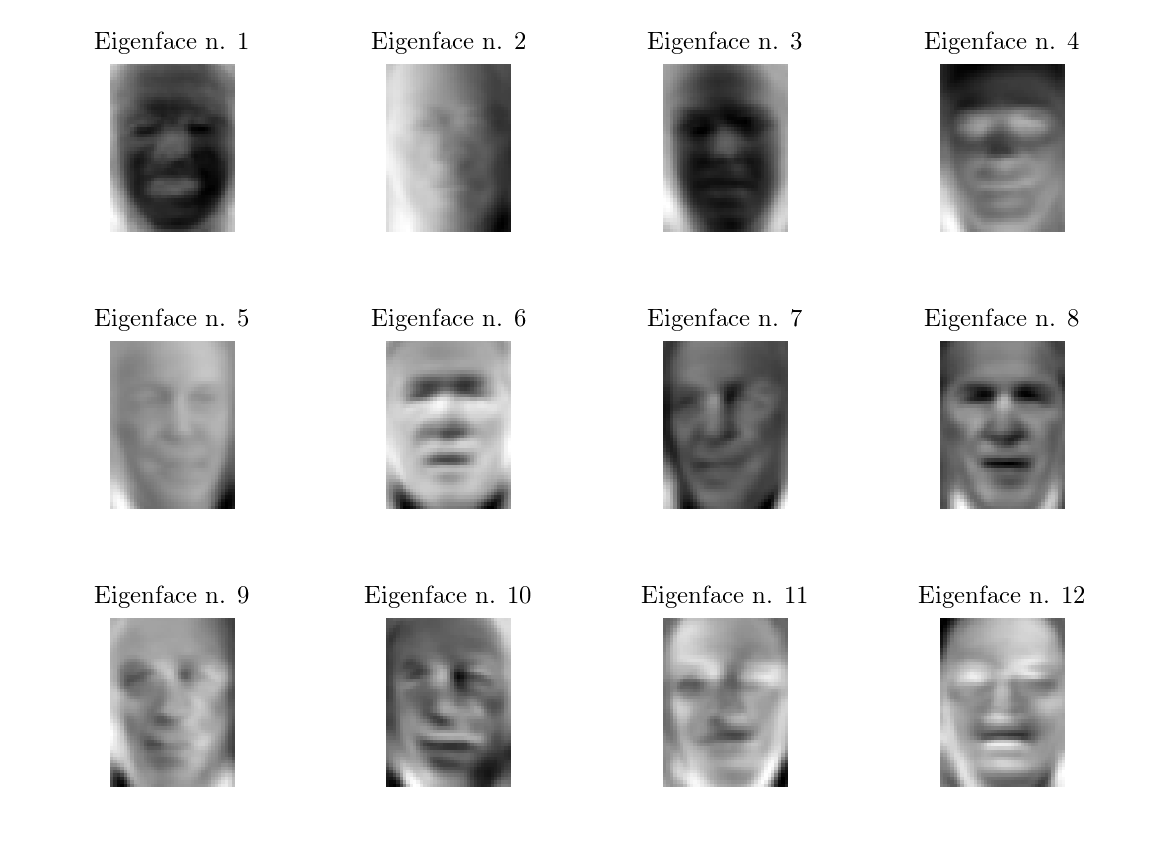

In [6]:
ef_100 = pca_100.components_.reshape((100, w, h))
ef_150 = pca_150.components_.reshape((150, w, h))
ef_200 = pca_200.components_.reshape((200, w, h))

fig, axes = plt.subplots(nrows=3, ncols=4)

# Print sample faces
for i in range(12): 
    plt.subplot(3, 4, i+1)
    plt.imshow(ef_100[i], cmap=plt.cm.gray)
    plt.title('Eigenface n. %d' % (i + 1), fontsize=10)
    plt.axis('off')

fig.tight_layout()
plt.show()

plt.savefig('eigenfaces.pdf')

We transform the data to get the low-dimensional representation of each image. We then build a partition of the space by training an SVM classifier with a RBF kernel in a one-versus-all approach. The RBF kernel takes the form

$$k(x,x')=\exp\{-\gamma\|x-x'\|\}.$$

The parameters of the SV classifier were adjusted experimentally ($C$, corresponding to the penalty term for margin violations).

Extracting principal components... 

<IPython.core.display.Javascript object>


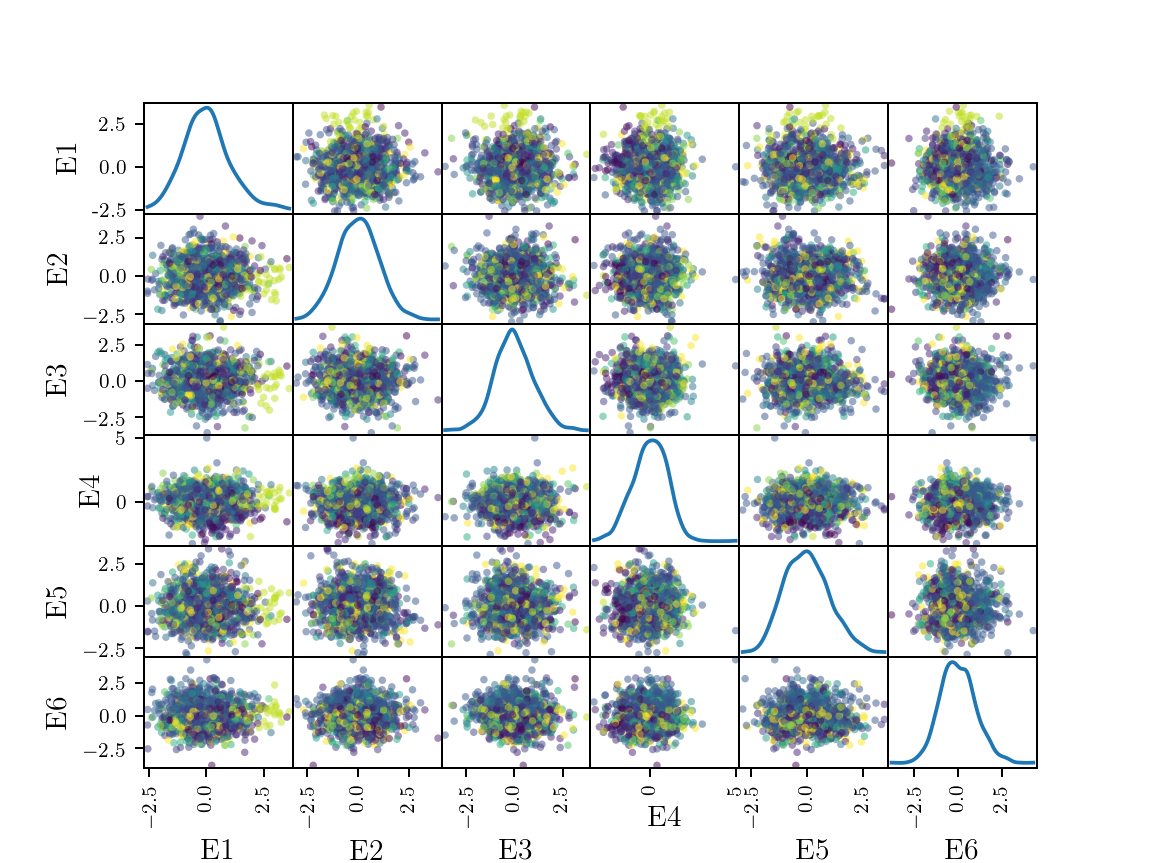

Done in 8 seconds.


In [7]:
print('Extracting principal components... ', end='')

t = time.time()

# Transform images into the principal components
X_train_100 = pca_100.transform(X_train)
X_test_100 = pca_100.transform(X_test)

X_train_150 = pca_150.transform(X_train)
X_test_150 = pca_150.transform(X_test)

X_train_200 = pca_200.transform(X_train)
X_test_200 = pca_200.transform(X_test)

# Visualization of of the dimensions

#   1. Transform data to pandas dataframe

aux = {'E1':X_train_100[:, 0],
       'E2':X_train_100[:, 1],
       'E3':X_train_100[:, 2],
       'E4':X_train_100[:, 3],
       'E5':X_train_100[:, 4],
       'E6':X_train_100[:, 5]}
#        ,'ID':y_train}

xpd = pd.DataFrame(aux)
scatter_matrix(xpd, c=y_train, diagonal='kde')
plt.savefig('scatter_matrix.pdf')

print('Done in %d seconds.' % (time.time() - t))

In [8]:
print('Training classifiers... ', end='')

t = time.time()

# Parameters for the different classifiers:
#
# 100-dimensional data: C = 1; gamma = 0.005;
# 150-dimensional data: C = 1; gamma = 0.005;
# 200-dimensional data: C = 1; gamma = 0.005;

svc100 = SVC(C=1, kernel='rbf', gamma=0.005, class_weight='balanced')
svc150 = SVC(C=1, kernel='rbf', gamma=0.005, class_weight='balanced')
svc200 = SVC(C=1, kernel='rbf', gamma=0.005, class_weight='balanced')

svc100.fit(X_train_100, y_train)
svc150.fit(X_train_150, y_train)
svc200.fit(X_train_200, y_train)

print('Done in %d seconds.' % (time.time() - t))

Training classifiers... Done in 1 seconds.


We now test the trained classifiers in the test set.

In [9]:
# Compute classifier predictions
ypred_100 = svc100.predict(X_test_100)
ypred_150 = svc150.predict(X_test_150)
ypred_200 = svc200.predict(X_test_200)

# Check accuracy
print(classification_report(y_test, ypred_100, target_names=people.target_names))
print(classification_report(y_test, ypred_150, target_names=people.target_names))
print(classification_report(y_test, ypred_200, target_names=people.target_names))

c100 = confusion_matrix(y_test, ypred_100)
c150 = confusion_matrix(y_test, ypred_150)
c200 = confusion_matrix(y_test, ypred_200)

print('Accuracy using 100 eigenfaces on %d images (g = 0.005):' % len(y_test), np.trace(c100) / len(y_test))
print('Accuracy using 150 eigenfaces on %d images (g = 0.005):' % len(y_test), np.trace(c150) / len(y_test))
print('Accuracy using 200 eigenfaces on %d images (g = 0.005):' % len(y_test), np.trace(c200) / len(y_test))


                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.88      0.74        16
     Colin Powell       0.85      0.91      0.88        66
  Donald Rumsfeld       0.68      0.78      0.72        27
    George W Bush       0.97      0.79      0.87       140
Gerhard Schroeder       0.78      0.88      0.82        24
      Hugo Chavez       0.76      0.76      0.76        17
   Jacques Chirac       0.78      0.70      0.74        10
    Jean Chretien       0.92      0.79      0.85        14
    John Ashcroft       0.75      0.94      0.83        16
Junichiro Koizumi       1.00      0.82      0.90        11
  Serena Williams       0.67      0.89      0.76         9
       Tony Blair       0.77      0.90      0.83        40

      avg / total       0.85      0.83      0.84       390

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.75      0.73        16
     Colin Powell       0.72      0.95      0.82    

### Bias / variance tradeoff

In [61]:
NBASIS = 100
NSETS  = 100

# Compute bias-variance

err_test = np.zeros([NBASIS, NSETS])

i = 0

for n_comp in log_progress(range(1, NBASIS + 1), every=1):
    
    for n_set in range(NSETS):
        
        # We build a new train-test split
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.25)

        pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True).fit(x1)

        # Transform data
        x1 = pca.transform(x1)
        x2 = pca.transform(x2)

        # Train classifier
        svm_classifier = SVC(C=50, kernel='rbf', gamma=0.005, class_weight='balanced')
        svm_classifier.fit(x1, y1)

        # Compute train and test errors
        ypred  = svm_classifier.predict(x2)

        # Check accuracy
        c_test  = confusion_matrix(y2, ypred)

        err_test[i, n_set] = 1 - np.trace(c_test) / len(y_test)

    i = i + 1

In [62]:
%store NBASIS
%store NSETS
%store err_test

Stored 'NBASIS' (int)
Stored 'NSETS' (int)
Stored 'err_test' (ndarray)


In [10]:
%store -r

<IPython.core.display.Javascript object>


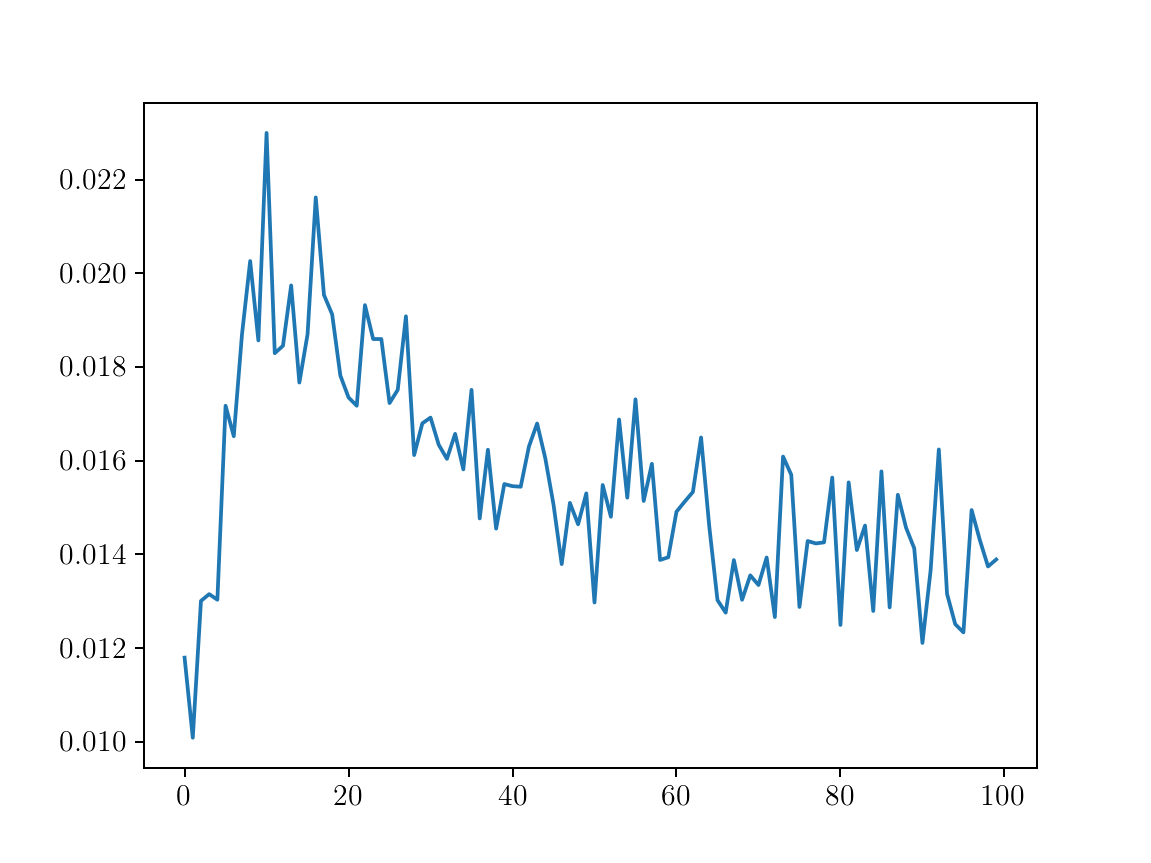

<IPython.core.display.Javascript object>


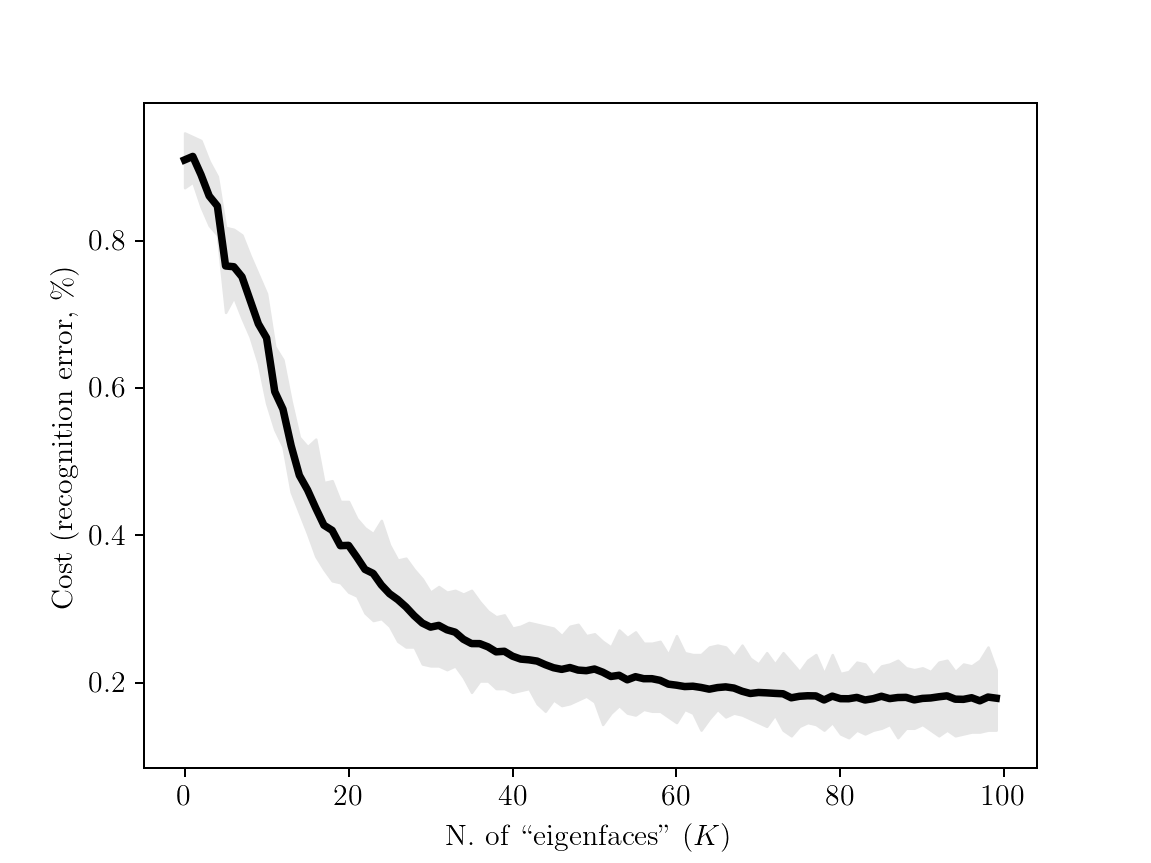

In [66]:
err_mean = np.mean(err_test, axis=1, keepdims=True)
err_dev = np.mean(abs(err_test-err_mean), axis=1, keepdims=True)

err_plus = np.max(err_test, axis=1);
err_minus = np.min(err_test, axis=1);

plt.figure()
plt.plot(err_dev)

plt.figure()
plt.plot(err_mean, 'k-', linewidth=3)
plt.fill_between(range(NBASIS), err_minus, err_plus, color=[0.9, 0.9, 0.9, 1.0])
plt.xlabel("N. of ``eigenfaces'' ($K$)")
plt.ylabel('Cost (recognition error, \%)')

plt.show()
plt.savefig('bias-variance.pdf')
plt.show()



### Overfitting

In [20]:
NBASIS = 200

# Showcase overfitting

err_train = np.zeros([NBASIS, 1])
err_test = np.zeros([NBASIS, 1])

for n_comp in log_progress(range(1, NBASIS + 1), every=1):

    # Select eigenfaces
    pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True).fit(X_train)

    # Transform data
    x_train = pca.transform(X_train)
    x_test = pca.transform(X_test)
    
    # Train classifier
    svm_classifier = SVC(C=50, kernel='rbf', gamma=0.005, class_weight='balanced')
    svm_classifier.fit(x_train, y_train)
    
    # Compute train and test errors
    ypred_train = svm_classifier.predict(x_train)
    ypred_test  = svm_classifier.predict(x_test)

    # Check accuracy
    c_train = confusion_matrix(y_train, ypred_train)
    c_test  = confusion_matrix(y_test, ypred_test)

    err_train[n_comp - 1] = 1 - np.trace(c_train) / len(y_train)
    err_test[n_comp - 1] = 1 - np.trace(c_test) / len(y_test)

<IPython.core.display.Javascript object>


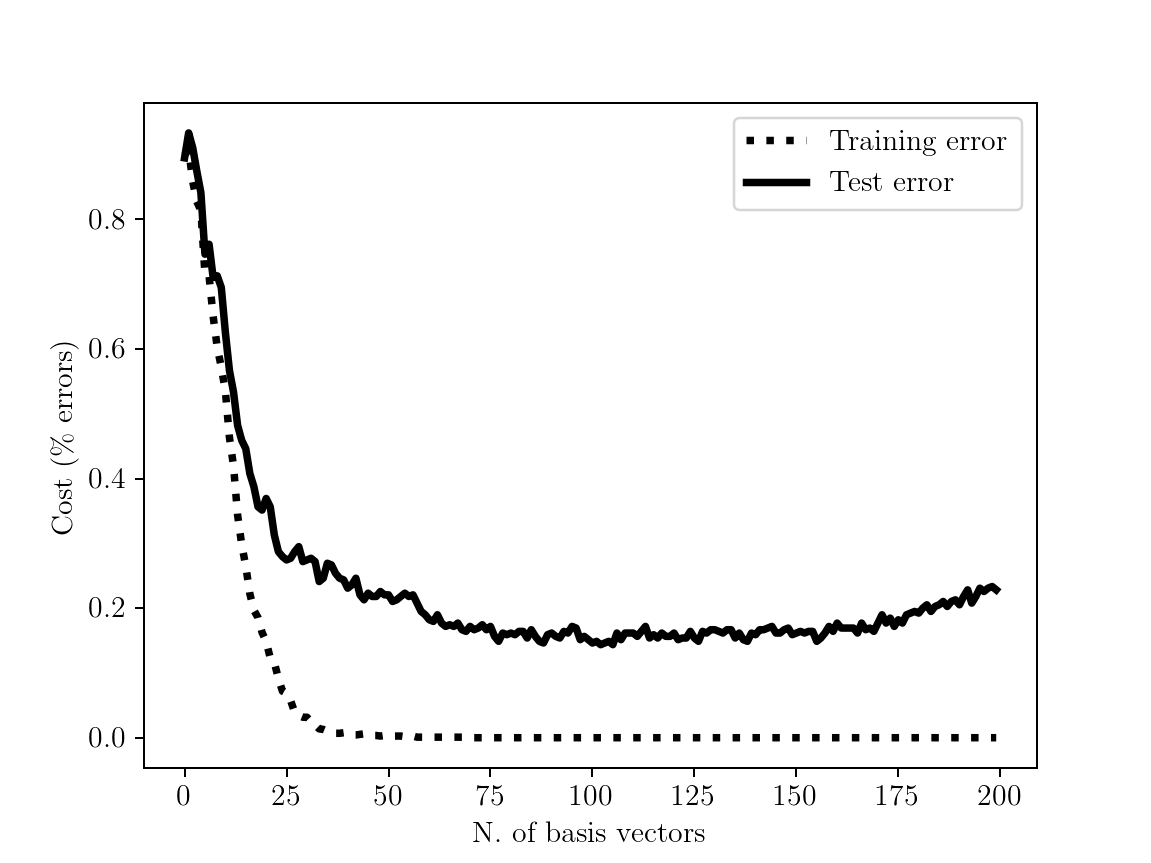

In [21]:
plt.figure()
plt.plot(err_train, 'k:', linewidth=3, label='Training error')
plt.plot(err_test, 'k-', linewidth=3, label='Test error')
plt.xlabel('N. of basis vectors')
plt.ylabel('Cost (\% errors)')
plt.legend(loc = 'best')

plt.show()
plt.savefig('overfit.pdf')

### Regularization

In [28]:
c_array = [1e-4, 1e-3, 1e-2, 1e-1, 1]

err_test = np.zeros([NBASIS, 5])

for n_comp in log_progress(range(1, NBASIS + 1), every=1):
    
    # Select eigenfaces
    pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True).fit(X_train)

    # Transform data
    x_train = pca.transform(X_train)
    x_test = pca.transform(X_test)

    for i in range(len(c_array)):

        # Train classifier
        svm_classifier = SVC(C=c_array[i], kernel='rbf', gamma=0.005, class_weight='balanced')
        svm_classifier.fit(x_train, y_train)

        # Compute test error
        ypred_test  = svm_classifier.predict(x_test)
        c_test  = confusion_matrix(y_test, ypred_test)
        err_test[n_comp - 1, i] = 1 - np.trace(c_test) / len(y_test)

<IPython.core.display.Javascript object>


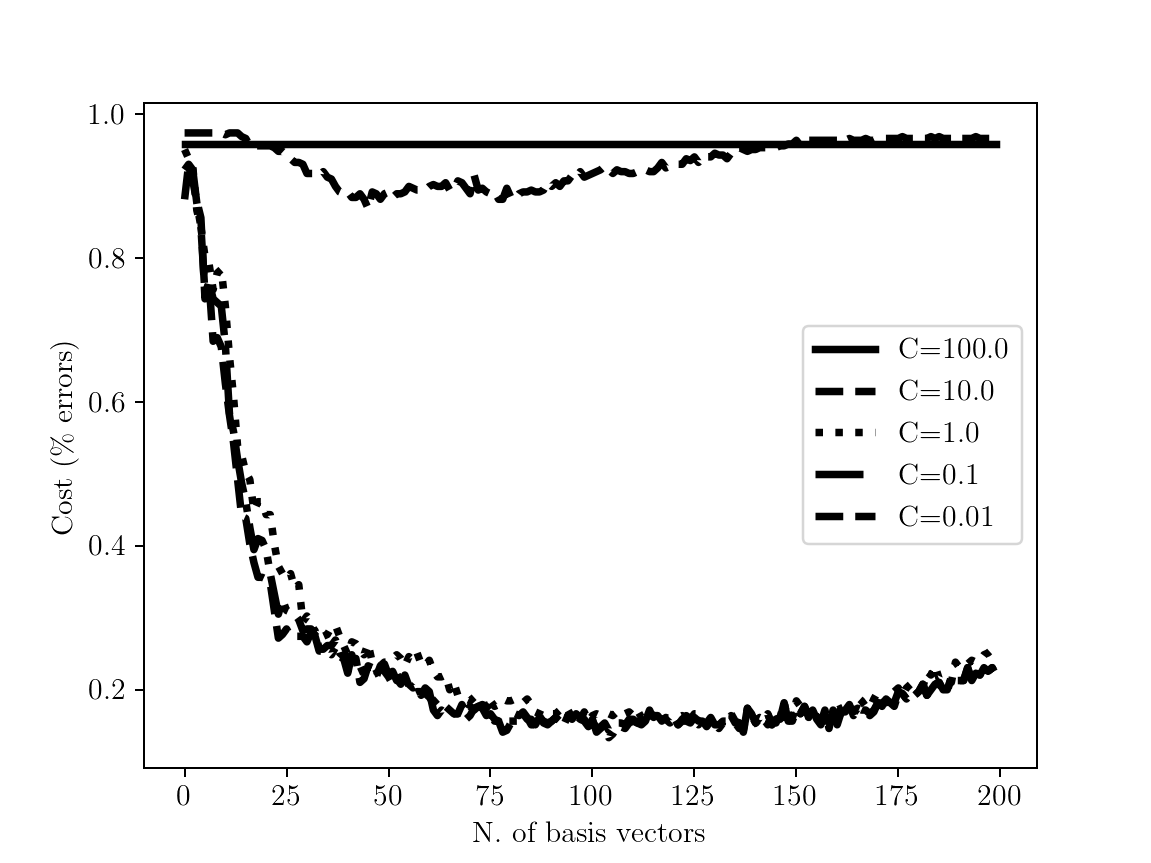

In [27]:
plt.figure()

line = ['-','--',':','-.', '--']
for i in range(len(c_array)):
    plt.plot(err_test[:, i], 'k' + line[i], linewidth=3, label='C=' + str(1/c_array[i]))    

plt.xlabel('N. of basis vectors')
plt.ylabel('Cost (\% errors)')
plt.legend(loc = 'best')

plt.show()
plt.savefig('regularization.pdf')

### Basics

Machine learning basic tools -- such as the entropy.

In [ ]:
# Tweak to avoid divide by zero
p = np.array([1] + list(range(1,100)) + [1])/ 100
h = -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Fill in missing values
p[0] = 0.
p[-1] = 1.

h[0] = 0.
h[-1] = 0.

# Plot entropy

plt.figure()
plt.plot(p, h, 'k', linewidth=3)
plt.xlabel(r'$N_0/N$')
plt.ylabel(r'$H(\mathcal{D})$')
plt.show()
plt.savefig('entropy.pdf')

### Spam filtering

Tests conducted with the e-mail dataset from the Ling-Spam corpus.

#### Step 1. Functions to extract relevant wordlist and features from text

We define a funcion `get_wordlist` which is used to go over the text in the e-mails and extract the most frequent words. Those words will be used as the features in the text.

We also define a second function, `extract_features`, used to express a set of e-mail messages each as a vector of numerical features (the counting of the corresponding words).

In [ ]:
# Build feature set

def get_wordlist(folders):
    """
        get_wordlist : list u str -> list
        
        get_wordlist(l) retrieves the 3000 most common words from the files in the 
        list of folders l.
        get_wordlist(f) retrieves the 3000 most common words from the files in f.
        
        :param folders: list
        :return list
    """
    words = []

    errors = 0
    ok = 0

    if isinstance(folders, str):
        folders = [folders]
    elif not isinstance(folders, list):
        raise TypeError('get_wordlist: invalid arguments')

    print('Processing folders... ', flush=True, end='')
    
    files = []
    for training_dir in folders:
        files += [os.path.join(training_dir, f) for f in os.listdir(training_dir)]

    print('Done.\nProcessing files... ', flush=True, end='')

    for f in log_progress(files, every=100):
        fin = open(f, 'r')
        try:
            words += str(fin.read()).split()        
            ok += 1
        except:
            errors += 1
        fin.close()

    print('Done.\nFound a total of', ok + errors, 'files.')
    print('Succeeded in reading', ok, 'files properly.')
    print('Failure in reading', errors, 'files.')

    d = Counter(words)
    keys = list(d.keys())

    print('Processing words... ', flush=True, end='')
    for k in keys:
        if not k.isalpha(): 
            del(d[k])
        elif len(k) == 1:
            del(d[k])

    d = d.most_common(3000)
    wordlist = [x[0] for x in d]
    wordlist.sort()
    print('Done.')
    
    return wordlist

# -- End: get_wordlist


def extract_features(folder, wordlist):
    """ 
        extract_features : str x list -> np.ndarray
        
        extract_features(f, l) represents each of the files in f as a feature 
        vector, where the features are the occurrences of the words in l.
        
        :param folder: str
        :param wordlist: list
        :return np.ndarray
    """

    x = []

    files = [os.path.join(folder, f) for f in os.listdir(folder)]
    
    print('Extracting features for folder', folder + '... ', flush=True, end='')
    
    for f in log_progress(files, every=100):
        fin = open(f, 'r')
        x_aux = []
        try:
            t = fin.read().split()
            for w in wordlist:
                x_aux += [t.count(w)]
            x += [x_aux]
        except:
            None
        fin.close()
       
    print('Done.')
    
    return np.array(x)

# -- End: extract_features

#### Step 2. Pre-process the training data

We now use the previous functions and prepare the training data.

In [ ]:
# Get word list
wordlist = get_wordlist(['./data/spam-filtering/nonspam-train', './data/spam-filtering/spam-train'])

# Extract feature
Xp = extract_features('./data/spam-filtering/nonspam-train', wordlist)
Xm = extract_features('./data/spam-filtering/spam-train', wordlist)

yp = np.ones(Xp.shape[0])
ym = np.zeros(Xm.shape[0])

X = np.concatenate((Xp, Xm), axis=0)
y = np.concatenate((yp, ym))

#### Step 3. Fit the models

After preprocessing the training data, we now fit a Naive Bayes and an SVM model to the data.

In [ ]:
print('Fitting models... ', flush=True, end='')
tdt = time.time()
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y)
tdt = time.time() - tdt
print('Decision tree done in', tdt, 'seconds.')

tlr = time.time()
lr_model = LogisticRegression()
lr_model.fit(X, y)
tlr = time.time() - tlr
print('Logistic regression done in', tlr, 'seconds.')

tnb = time.time()
nb_model = MultinomialNB()
nb_model.fit(X, y)
tnb = time.time() - tnb
print('Naive Bayes done in', tnb, 'seconds.')

tknn = time.time()
knn_model = KNeighborsClassifier(5, weights='distance')
knn_model.fit(X, y)
tknn = time.time() - tknn
print('k-Nearest Neighbors done in', tknn, 'seconds.')

tsvm = time.time()
svm_model = LinearSVC()
svm_model.fit(X, y)
tsvm = time.time() - tsvm
print('Support Vector Machines done in', tsvm, 'seconds.')

tnn = time.time()
nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 5) , random_state=1)
nn_model.fit(X, y)
tnn = time.time() - tnn
print('Multilayer Perceptron done in', tnn, 'seconds.')

print('Done.')

#### Step 4. Test the models

We can now test the learned models with unseen data.

In [ ]:
# Extract feature
Xp = extract_features('./data/spam-filtering/nonspam-test', wordlist)
Xm = extract_features('./data/spam-filtering/spam-test', wordlist)

yp = np.ones(Xp.shape[0])
ym = np.zeros(Xm.shape[0])

Xtest = np.concatenate((Xp, Xm), axis=0)
ytest = np.concatenate((yp, ym))

In [ ]:
y_dt = dt_model.predict(Xtest)
y_lr = lr_model.predict(Xtest)
y_nb = nb_model.predict(Xtest)
y_knn = knn_model.predict(Xtest)
y_svm = svm_model.predict(Xtest)
y_nn = nn_model.predict(Xtest)

dt_results = confusion_matrix(ytest, y_dt)
lr_results = confusion_matrix(ytest, y_lr)
nb_results = confusion_matrix(ytest, y_nb)
knn_results = confusion_matrix(ytest, y_knn)
svm_results = confusion_matrix(ytest, y_svm)
nn_results = confusion_matrix(ytest, y_nn)

print('\n-- Results (Decision Tree) -- \n')
print('Accuracy: {:.2%}'.format((dt_results[0, 0] + dt_results[1, 1]) / dt_results.sum().sum()))
print('Precision: {:.2%}'.format(dt_results[0, 0] / dt_results[:, 0].sum()))
print('Recall: {:.2%}'.format(dt_results[0, 0] / dt_results[0, :].sum()))

print('\n-- Results (Logistic Regression) -- \n')
print('Accuracy: {:.2%}'.format((lr_results[0, 0] + lr_results[1, 1]) / lr_results.sum().sum()))
print('Precision: {:.2%}'.format(lr_results[0, 0] / lr_results[:, 0].sum()))
print('Recall: {:.2%}'.format(lr_results[0, 0] / lr_results[0, :].sum()))

print('\n-- Results (Naive Bayes) -- \n')
print('Accuracy: {:.2%}'.format((nb_results[0, 0] + nb_results[1, 1]) / nb_results.sum().sum()))
print('Precision: {:.2%}'.format(nb_results[0, 0] / nb_results[:, 0].sum()))
print('Recall: {:.2%}'.format(nb_results[0, 0] / nb_results[0, :].sum()))

print('\n-- Results (k-Nearest Neighbors) -- \n')
print('Accuracy: {:.2%}'.format((knn_results[0, 0] + knn_results[1, 1]) / knn_results.sum().sum()))
print('Precision: {:.2%}'.format(knn_results[0, 0] / knn_results[:, 0].sum()))
print('Recall: {:.2%}'.format(knn_results[0, 0] / knn_results[0, :].sum()))

print('\n-- Results (Support Vector Machines) -- \n')
print('Accuracy: {:.2%}'.format((svm_results[0, 0] + svm_results[1, 1]) / svm_results.sum().sum()))
print('Precision: {:.2%}'.format(svm_results[0, 0] / svm_results[:, 0].sum()))
print('Recall: {:.2%}'.format(svm_results[0, 0] / svm_results[0, :].sum()))

print('\n-- Results (Neural Networks) -- \n')
print('Accuracy: {:.2%}'.format((nn_results[0, 0] + nn_results[1, 1]) / nn_results.sum().sum()))
print('Precision: {:.2%}'.format(nn_results[0, 0] / nn_results[:, 0].sum()))
print('Recall: {:.2%}'.format(nn_results[0, 0] / nn_results[0, :].sum()))

### Discriminating IRIS flowers

The IRIS flower data set is a data set describing the morphologic variation of Iris flowers of three related species. Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

#### Step 1. Load the dataset

We start by loading the dataset, and restrict to two of the labels and two of the attributes, for pedagogical purposes.

In [ ]:
# Load dataset
iris = datasets.load_iris()

# Get data for the two classes that matter
X = iris.data[50:,2:]
a = iris.target[50:]

# Plot data
plt.figure()
plt.plot(X[:50, 0], X[:50, 1], 'bx', label='Versicolor')
plt.plot(X[50:, 0], X[50:, 1], 'ro', label='Setosa')
plt.xlabel('$\phi_l(x)$ (Petal length, cm)')
plt.ylabel('$\phi_w(x)$ (Petal width, cm)')
plt.legend(loc='best')
plt.show()
plt.savefig('iris-dataset.pdf')

#### Step 2. Train the model

We now fit a decision tree model to the data.

In [ ]:
print('Fitting models... ', flush=True, end='')
tdt = time.time()
dt_model = DecisionTreeClassifier()
dt_model.fit(X, a)
tdt = time.time() - tdt
print('Decision tree done in', tdt, 'seconds.')

#### Step 3. Test model

We now observe the resulting classifier

In [ ]:
# Plot decision boundary
xmin = X[:, 0].min() - 0.1
xmax = X[:, 0].max() + 0.1
ymin = X[:, 1].min() - 0.1
ymax = X[:, 1].max() + 0.1

# Build mesh of values
xl, xw = np.meshgrid(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01))

# Vectorize and concatenate points in the grid
x_test = np.c_[xl.ravel(), xw.ravel()]

# Predict
y_pred = dt_model.predict(x_test).reshape(xl.shape)

# Plot
cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])

fig = plt.figure()

# Mesh
plt.pcolormesh(xl, xw, y_pred, cmap=cmap_light)

# Dataset
plt.plot(X[:50, 0], X[:50, 1], 'bx', label='Versicolor')
plt.plot(X[50:, 0], X[50:, 1], 'ro', label='Setosa')

# Boundaries
plt.plot([xmin, xmax], [1.75, 1.75], 'k--')
plt.plot([4.95, 4.95], [ymin, 1.75], 'k--')
plt.plot([xmin, 4.95], [1.65, 1.65], 'k--')
plt.plot([4.95,xmax], [1.55, 1.55], 'k--')
plt.plot([5.45,5.45], [1.55, 1.75], 'k--')

# Plot info
plt.xlabel('$\phi_l(x)$ (Petal length, cm)')
plt.ylabel('$\phi_w(x)$ (Petal width, cm)')
plt.legend(loc='best')
plt.axis([xmin, xmax, ymin, ymax])
plt.show()
plt.savefig('iris-dt-results.pdf')

### Breast cancer classification

Tests conducted with the e-mail dataset from the Ling-Spam corpus.

### Robot imitation

Tests conducted with a learning-from-demonstration robot scenario.